<a href="https://colab.research.google.com/github/starichokcoding/llm/blob/main/xgboost_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('/content/loan_dr_aws_apr2024_numeric.csv')

In [7]:
df

,loan_amnt,term,emp_length,annual_inc,is_bad
0,4000,60,10,50000.0,0
1,16000,60,1,39216.0,0
2,8700,36,4,65000.0,0
3,18000,60,10,57500.0,0
4,16000,36,10,50004.0,0
...,...,...,...,...,...
9478,8700,36,5,66250.0,0
9479,8000,36,1,26000.0,0
9480,16000,36,8,47831.0,0
9481,3600,60,6,70000.0,0


In [8]:
df0 = df[df['is_bad'] == 0]
df1 = df[df['is_bad'] == 1]
df_new = pd.concat([df0.sample(frac=0.1), df1.sample(frac=0.5)])

In [9]:
df_list = [df, df0, df1, df_new]
[len(_) for _ in df_list]

[9483, 8261, 1222, 1437]

In [10]:
df_new.to_csv('out.csv', index=False)

In [24]:
import xgboost
import numpy as np
from sklearn.model_selection import train_test_split
import shap

In [25]:
X, y = df.drop('is_bad', axis=1), df[['is_bad']]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [27]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [28]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.39860
[100]	test-logloss:0.38527
[143]	test-logloss:0.38479


In [29]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

 99%|===================| 9422/9483 [01:12<00:00]       

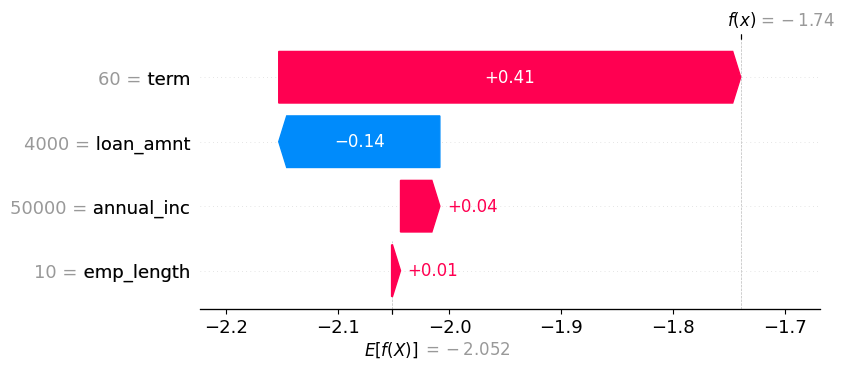

In [30]:
shap.plots.waterfall(shap_values[0])

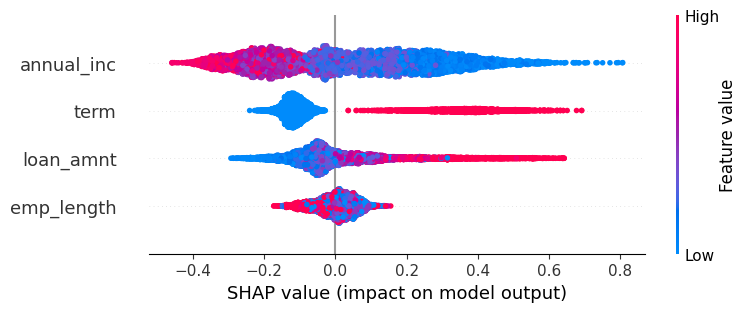

In [31]:
shap.plots.beeswarm(shap_values)

In [32]:
loan_amnt = int(input("what is the loan amount you would like to get?:"))
term = int(input("Would you like for 36 or 60 months?:"))
emp_length = int(input("How many years of employment do you have?:"))
annual_inc = int(input("what is your annual income in $:"))

what is the loan amount you would like to get?:90000
Would you like for 36 or 60 months?:100
How many years of employment do you have?:1
what is your annual income in $:1000


In [33]:
data = pd.DataFrame({'loan_amnt': [loan_amnt],
        'term': [term],
        'emp_length': [emp_length],
        'annual_inc': [annual_inc]})
data_new = xgboost.DMatrix(data)
prediction = model.predict(data_new)
prediction[0]

0.2951859

In [34]:
data

,loan_amnt,term,emp_length,annual_inc
0,90000,100,1,1000


In [35]:
explainer_x = shap.Explainer(model, X)
shap_values_x = explainer_x(data)

In [36]:
shap_values[0]

.values =
array([-0.14412111,  0.41316902,  0.00797757,  0.03521216])

.base_values =
-2.0517928769324074

.data =
array([4.e+03, 6.e+01, 1.e+01, 5.e+04])

In [37]:
shap_values_x

.values =
array([[0.28098165, 0.39012206, 0.01521291, 0.3985015 ]])

.base_values =
array([-2.05179288])

.data =
array([[90000,   100,     1,  1000]])

In [38]:
shap_values_x.values[0]

array([0.28098165, 0.39012206, 0.01521291, 0.3985015 ])

In [39]:
[_ for _ in zip(data.columns, shap_values_x.data[0], shap_values_x.values[0])]

[('loan_amnt', 90000, 0.2809816454140309),
 ('term', 100, 0.390122055675165),
 ('emp_length', 1, 0.01521291110322636),
 ('annual_inc', 1000, 0.3985015029262831)]

In [40]:
data.iloc[0].to_list()

[90000, 100, 1, 1000]

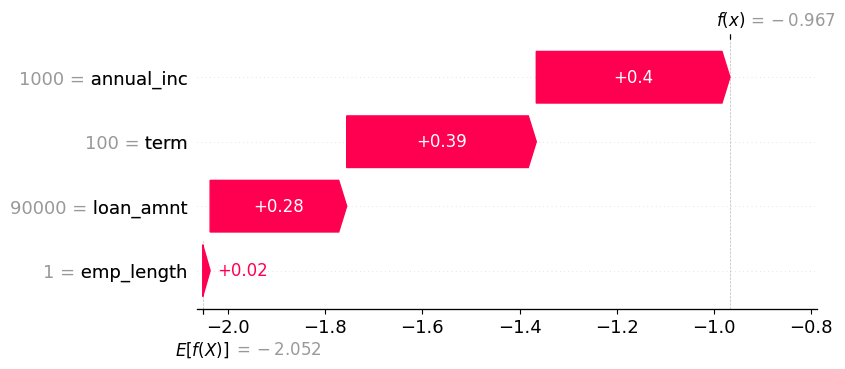

In [41]:
shap.plots.waterfall(shap_values_x[0])

In [42]:
!pip install openai==0.28

In [43]:
import openai
from google.colab import userdata
openai.api_key = userdata.get('openai')

In [52]:
max_token_size = 4097

def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.Completion.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    return response.choices[0].message["content"]

In [45]:
[_ for _ in zip(data.columns, shap_values_x.data[0], shap_values_x.values[0])]

[('loan_amnt', 90000, 0.2809816454140309),
 ('term', 100, 0.390122055675165),
 ('emp_length', 1, 0.01521291110322636),
 ('annual_inc', 1000, 0.3985015029262831)]

In [58]:
n_explanations = 3
def provide_rejection_advice(sample_1, shap_values_x, n_explanations):
    sample_1.fillna("not available", inplace=True)
    explanation_string = (
        data.columns[0]
        + " is "
        + str(shap_values_x.data[0][0])
        + " and Shapley value is "
        + str(shap_values_x.values[0][0])
        + ", "
        + data.columns[1]
        + " is "
        + str(shap_values_x.data[0][1])
        + " and Shapley value is "
        + str(shap_values_x.values[0][1])
        + ", "
        + data.columns[2]
        + " is "
        + str(shap_values_x.data[0][2])
        + " and Shapley value is "
        + str(shap_values_x.values[0][2])
        + ", "
        + data.columns[3]
        + " is "
        +str(shap_values_x.data[0][3])
        + " and Shapley value is "
        + str(shap_values_x.values[0][3])
    )
    explanation_string = (
        explanation_string.replace("loan_amnt", "loan amount")
        .replace("emp_length", "employment tenure")
        .replace(
            "term", "for how many month the loan is asked"
        )
        .replace("annual_inc", "annual income")
    )

    prompt = (
        'You are a telephonic loan sales representative. TBased on the model prediction of loan rejection for a customer due to the following reasons "'
        + explanation_string
        + '", please provide a positive sentiment reply to the customer with '
        + str(n_explanations)
        + " of the most urgent steps to improve the chances of loan approval. The base Shapley value is -2.05. Do not mention about any models or predictions in the response."
    )
    response = get_completion(prompt)
    return prompt, response

In [57]:
provide_rejection_advice(data, shap_values_x, n_explanations)

'You are a telephonic loan sales representative. TBased on the model prediction of loan rejection for a customer due to the following reasons "loan amount is 90000 and Shapley value is 0.2809816454140309, for how many month the loan is asked is 100 and Shapley value is 0.390122055675165, employment tenure is 1 and Shapley value is 0.01521291110322636, annual income is 1000 and Shapley value is 0.3985015029262831", please provide a positive sentiment reply to the customer with 3 of the most urgent steps to improve the chances of loan approval. The base Shapley value is -2.05. Do not mention about any models or predictions in the response.'

In [60]:
prompt, loan_rejection_advice = provide_rejection_advice(data, shap_values_x, n_explanations)
print(prompt)
print("=====================")
print(loan_rejection_advice)

RateLimitError: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.

In [49]:
data.columns[1]

'term'

In [44]:
explainer1 = shap.TreeExplainer(model)
shap_values1 = explainer1.shap_values(X)


In [46]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [14]:
cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
   X[col] = X[col].astype('category')
# y['is_bad'] = y['is_bad'].astype('category')

In [16]:
len(y_train[y_train['is_bad'] == 1])

962

In [17]:
tr_lect = [X_train, X_test, y_train, y_test]
[_.dtypes for _ in tr_lect]

[loan_amnt        int64
 term          category
 grade         category
 emp_length    category
 annual_inc     float64
 purpose       category
 dtype: object,
 loan_amnt        int64
 term          category
 grade         category
 emp_length    category
 annual_inc     float64
 purpose       category
 dtype: object,
 is_bad    int64
 dtype: object,
 is_bad    int64
 dtype: object]

In [127]:
model = xgboost.train(params, d_train)

In [19]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.40060
[100]	test-logloss:0.38208
[200]	test-logloss:0.37965
[231]	test-logloss:0.37995


In [23]:
prediction = model.predict(d_test)

In [26]:
np.sort(prediction)

array([0.02717113, 0.02880404, 0.02903808, ..., 0.46899396, 0.58092964,
       0.6045116 ], dtype=float32)

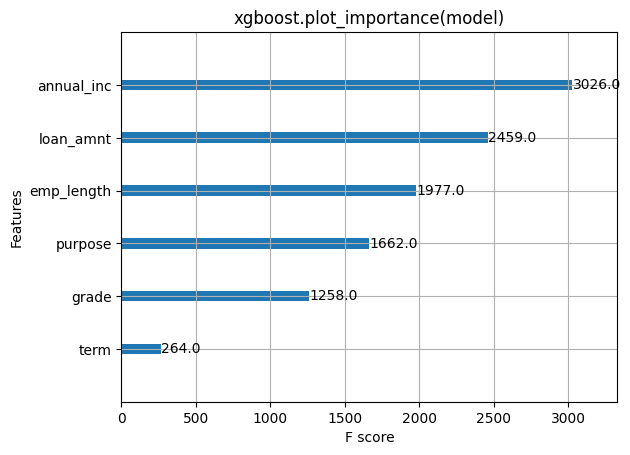

In [138]:
import matplotlib.pylab as pl
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

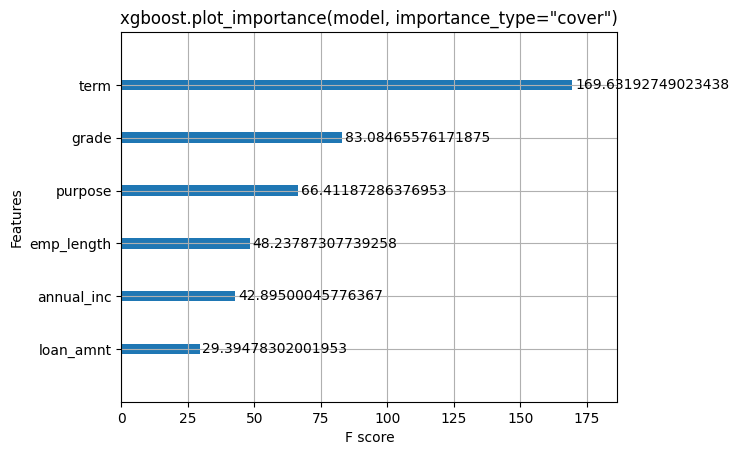

In [139]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

In [141]:
shap.TreeExplainer(model)


In [144]:
X

,loan_amnt,term,grade,emp_length,annual_inc,purpose
0,4000,60 months,A,10+ years,50000.0,medical
1,16000,60 months,F,< 1 year,39216.0,debt_consolidation
2,8700,36 months,A,4 years,65000.0,credit_card
3,18000,60 months,B,10+ years,57500.0,debt_consolidation
4,16000,36 months,B,10+ years,50004.0,debt_consolidation
...,...,...,...,...,...,...
9557,8700,36 months,A,5 years,66250.0,wedding
9558,8000,36 months,B,< 1 year,26000.0,debt_consolidation
9559,16000,36 months,C,8 years,47831.0,debt_consolidation
9560,3600,60 months,C,6 years,70000.0,major_purchase


In [146]:
y

,is_bad
0,0
1,0
2,0
3,0
4,0
...,...
9557,0
9558,0
9559,0
9560,0


In [123]:
model = xgboost.train(params, d_train, 10, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.40060
[9]	test-logloss:0.39702


In [125]:
xgb_clf = XGBClassifier(use_label_encoder=False)

In [126]:
xgb_clf.fit(X_train, y_train)

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

# print_score(y_train, y_train_pred, train=True)
# print_score(y_test, y_test_pred, train=False)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:term: category, grade: category, emp_length: category, purpose: category

In [124]:
!pip install shap

In [98]:
import shap

In [99]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [100]:
X

,loan_amnt,term,grade,emp_length,annual_inc,purpose
0,4000,60 months,A,10+ years,50000.0,medical
1,16000,60 months,F,< 1 year,39216.0,debt_consolidation
2,8700,36 months,A,4 years,65000.0,credit_card
3,18000,60 months,B,10+ years,57500.0,debt_consolidation
4,16000,36 months,B,10+ years,50004.0,debt_consolidation
...,...,...,...,...,...,...
9557,8700,36 months,A,5 years,66250.0,wedding
9558,8000,36 months,B,< 1 year,26000.0,debt_consolidation
9559,16000,36 months,C,8 years,47831.0,debt_consolidation
9560,3600,60 months,C,6 years,70000.0,major_purchase


In [7]:
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split

import shap

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)


In [ ]:
X, y

In [148]:

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [149]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.54663
[100]	test-logloss:0.36398
[200]	test-logloss:0.31758
[300]	test-logloss:0.30065
[400]	test-logloss:0.29170
[500]	test-logloss:0.28655
[600]	test-logloss:0.28358
[700]	test-logloss:0.28174
[800]	test-logloss:0.28061
[900]	test-logloss:0.27988
[1000]	test-logloss:0.27939
[1100]	test-logloss:0.27906
[1177]	test-logloss:0.27888


In [ ]:
model.predict(d_test, pred_interactions=True)

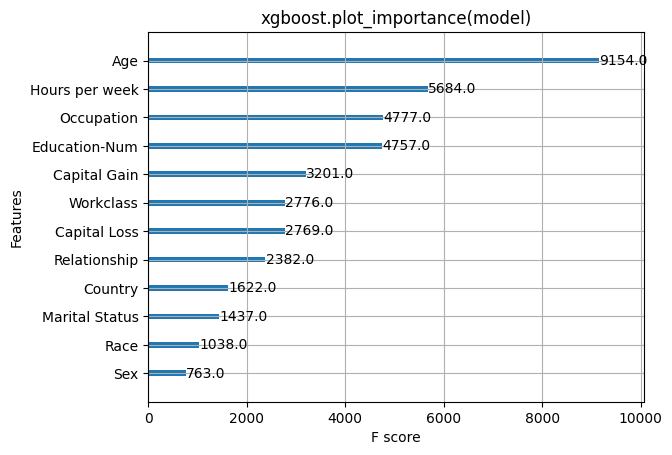

In [150]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

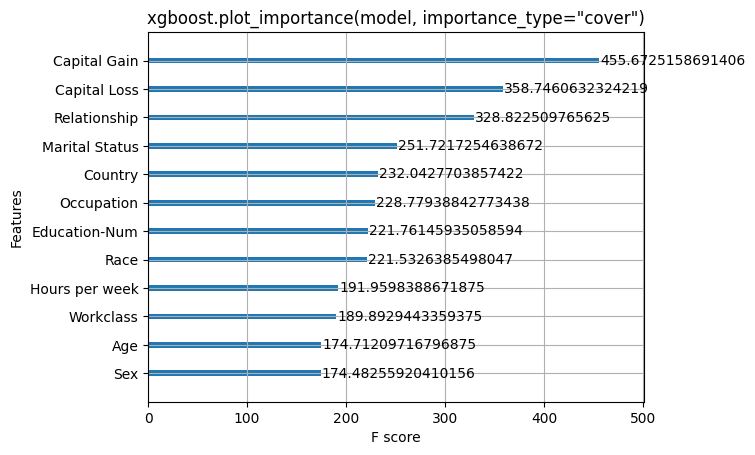

In [151]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

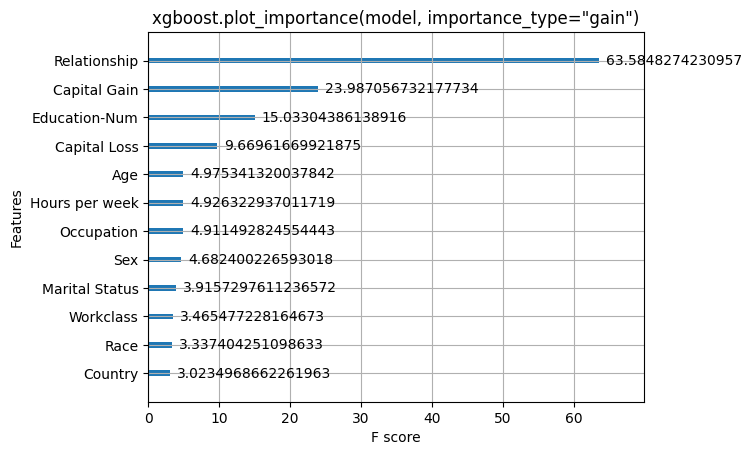

In [152]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

In [164]:
X

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,4,12.0,2,13,5,4,0,0.0,0.0,38.0,39
32557,40.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
32558,58.0,4,9.0,6,1,1,4,0,0.0,0.0,40.0,39
32559,22.0,4,9.0,4,1,3,4,1,0.0,0.0,20.0,39


In [153]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [161]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_display.iloc[0, :])


In [162]:
shap.force_plot(
    explainer.expected_value, shap_values[:1000, :], X_display.iloc[:1000, :]
)

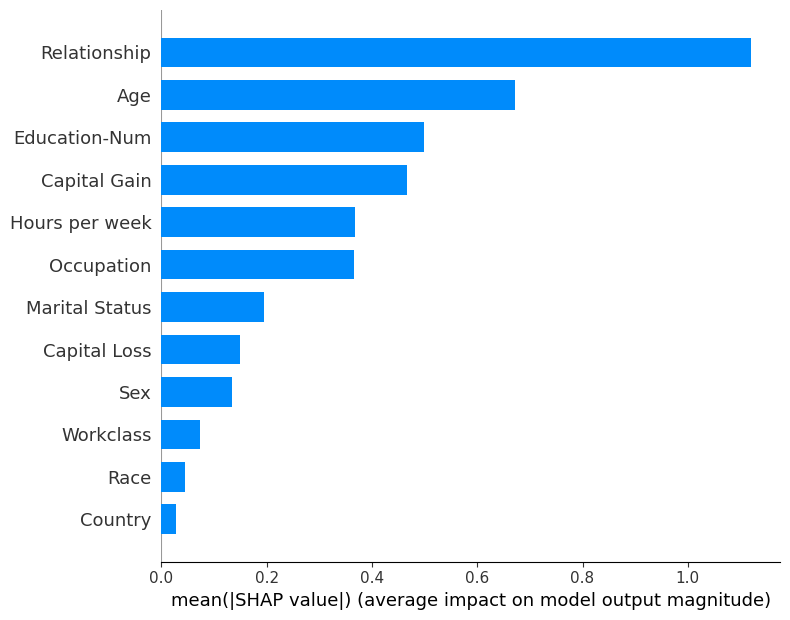

In [163]:
shap.summary_plot(shap_values, X_display, plot_type="bar")


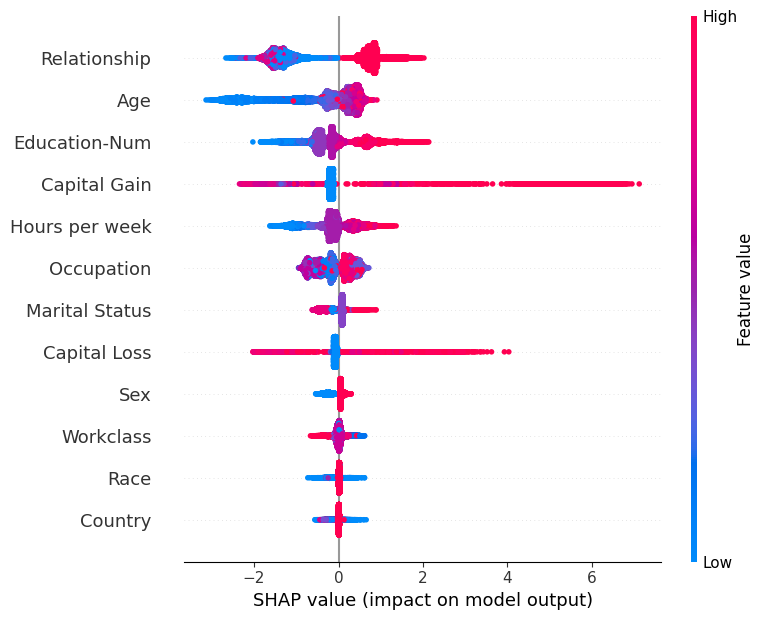

In [157]:
shap.summary_plot(shap_values, X)


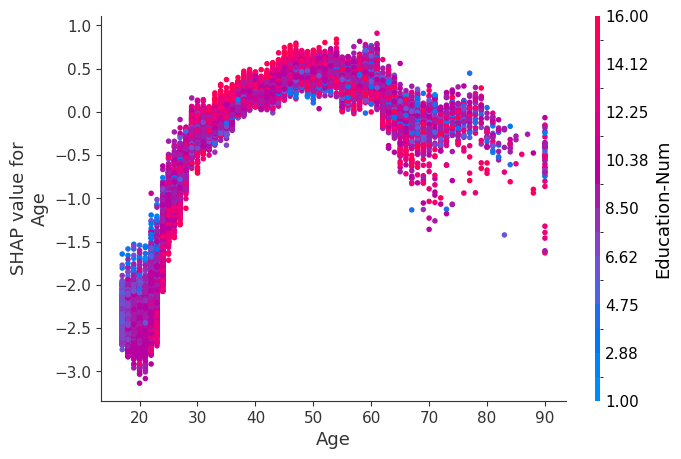

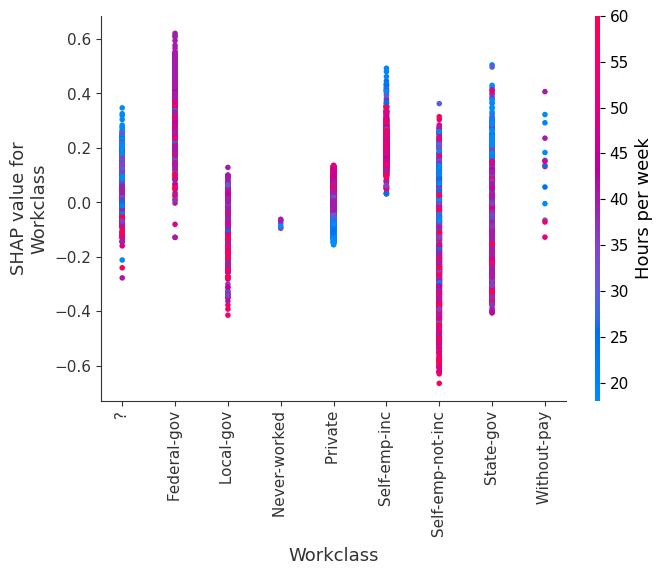

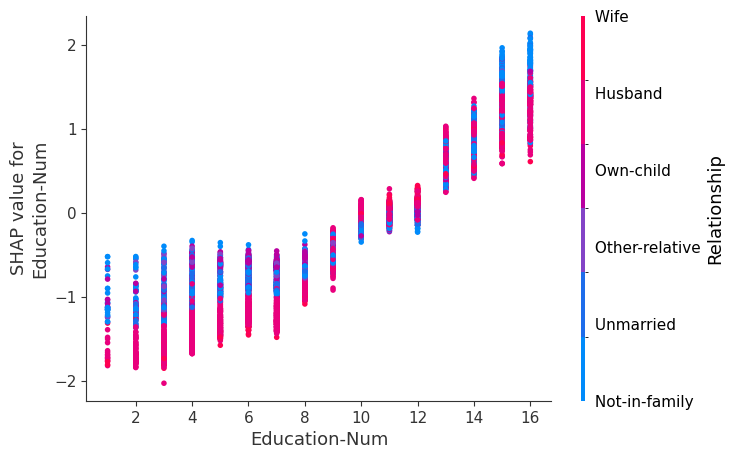

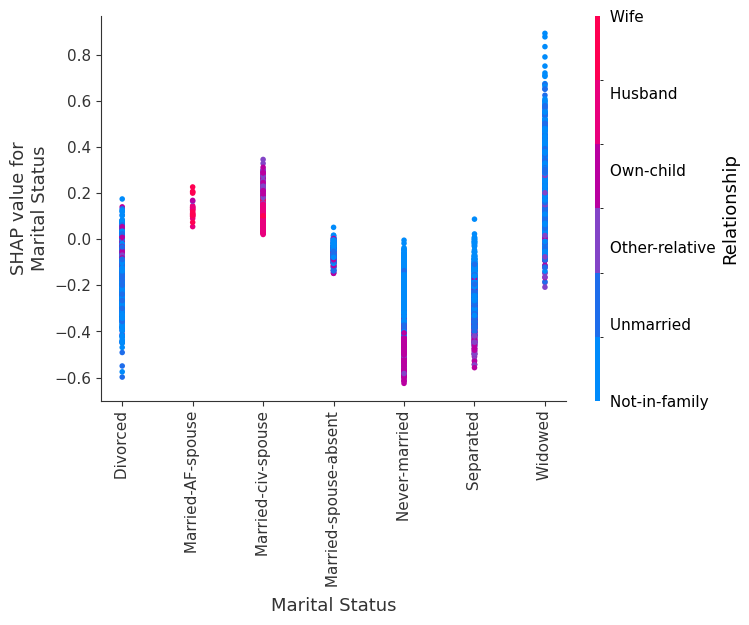

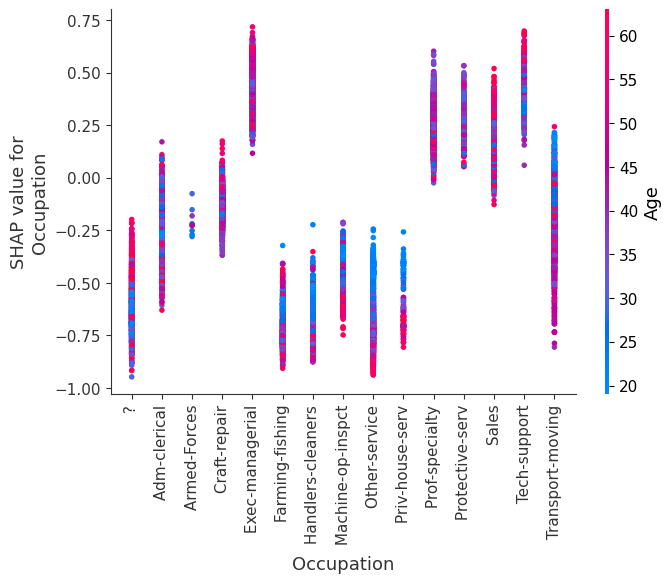

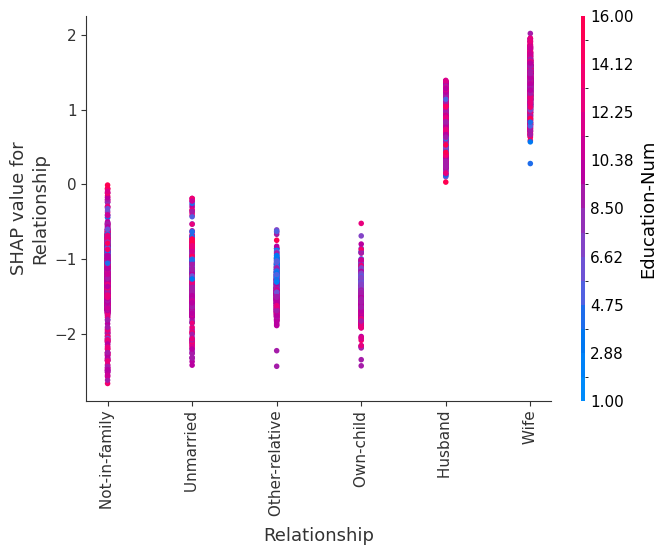

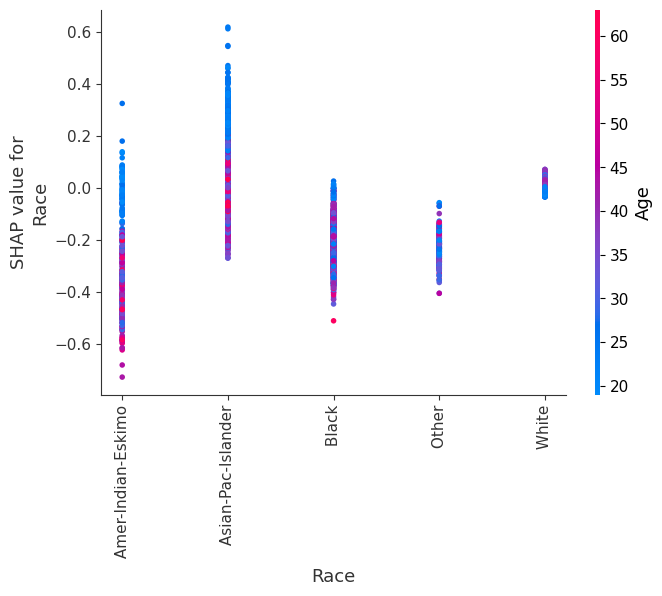

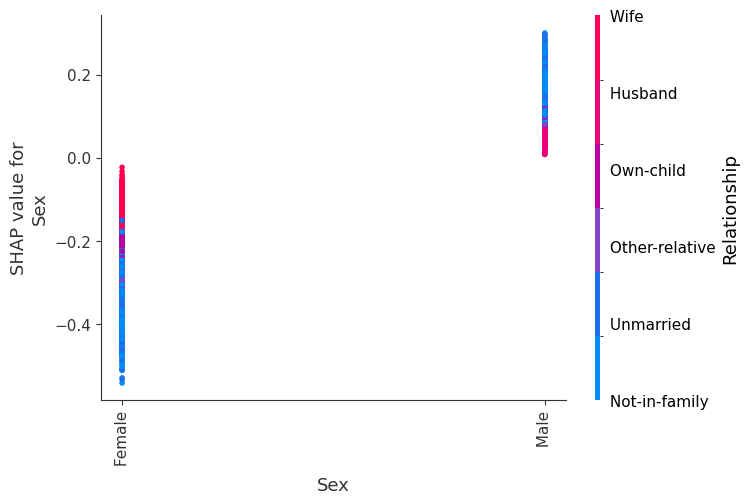

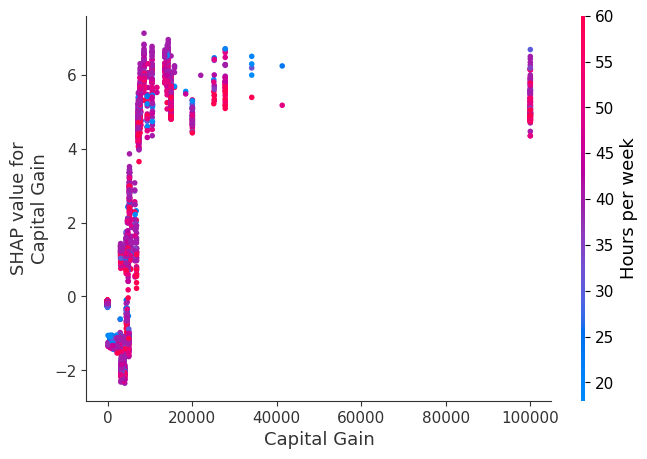

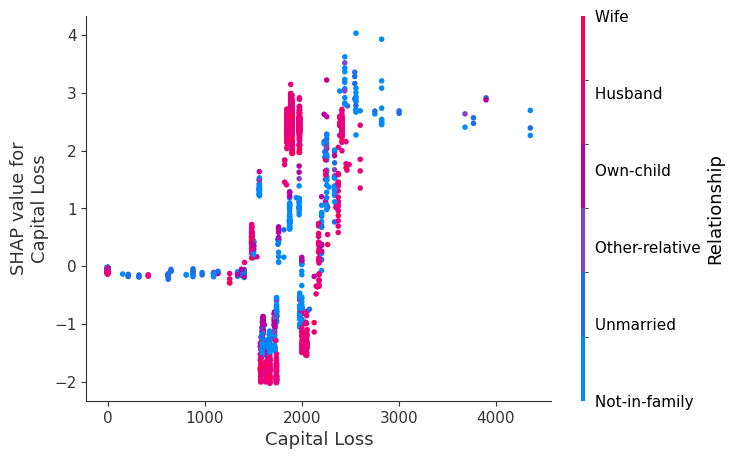

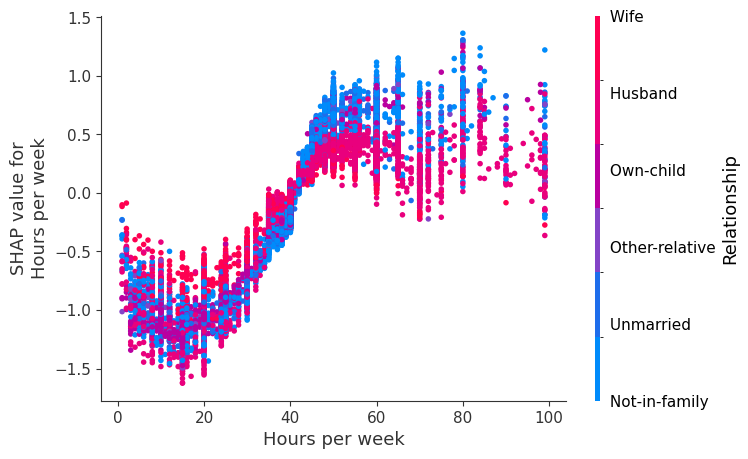

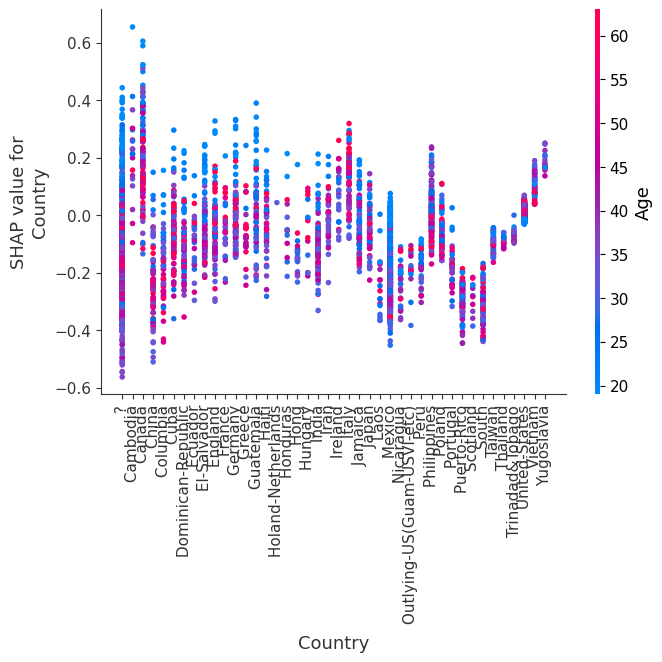

In [158]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)